In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, util, plot_style

Wji, pset, amp, dur, l_kernel, r_kernel = util.load_fiducial_network(True)

In [2]:
import os
os.getcwd()

'c:\\Users\\caele\\Desktop\\Spring2025\\miller-lab-final\\figures\\figure7'

In [22]:
def plot_reliabilities(ax, fname):
    # load reliabilities
    reliabilities = np.load(fname)
    # set axes (manually set)
    amp_range = np.logspace(0, 2, 50)
    dur_range = np.linspace(0, 0.1, 50)
    dur_mesh, amp_mesh = np.meshgrid(dur_range, amp_range) # amp on y-axis, duration on x-axis
    
    # plot
    c = ax.pcolormesh(dur_mesh, amp_mesh, reliabilities.reshape(dur_mesh.shape), cmap='viridis', shading='auto')
    ax.set_yscale('log')
    ax.set_xlabel(r"$\tau_{dur}$")
    ax.set_ylabel(r"$I_{app}$")
    
    return c


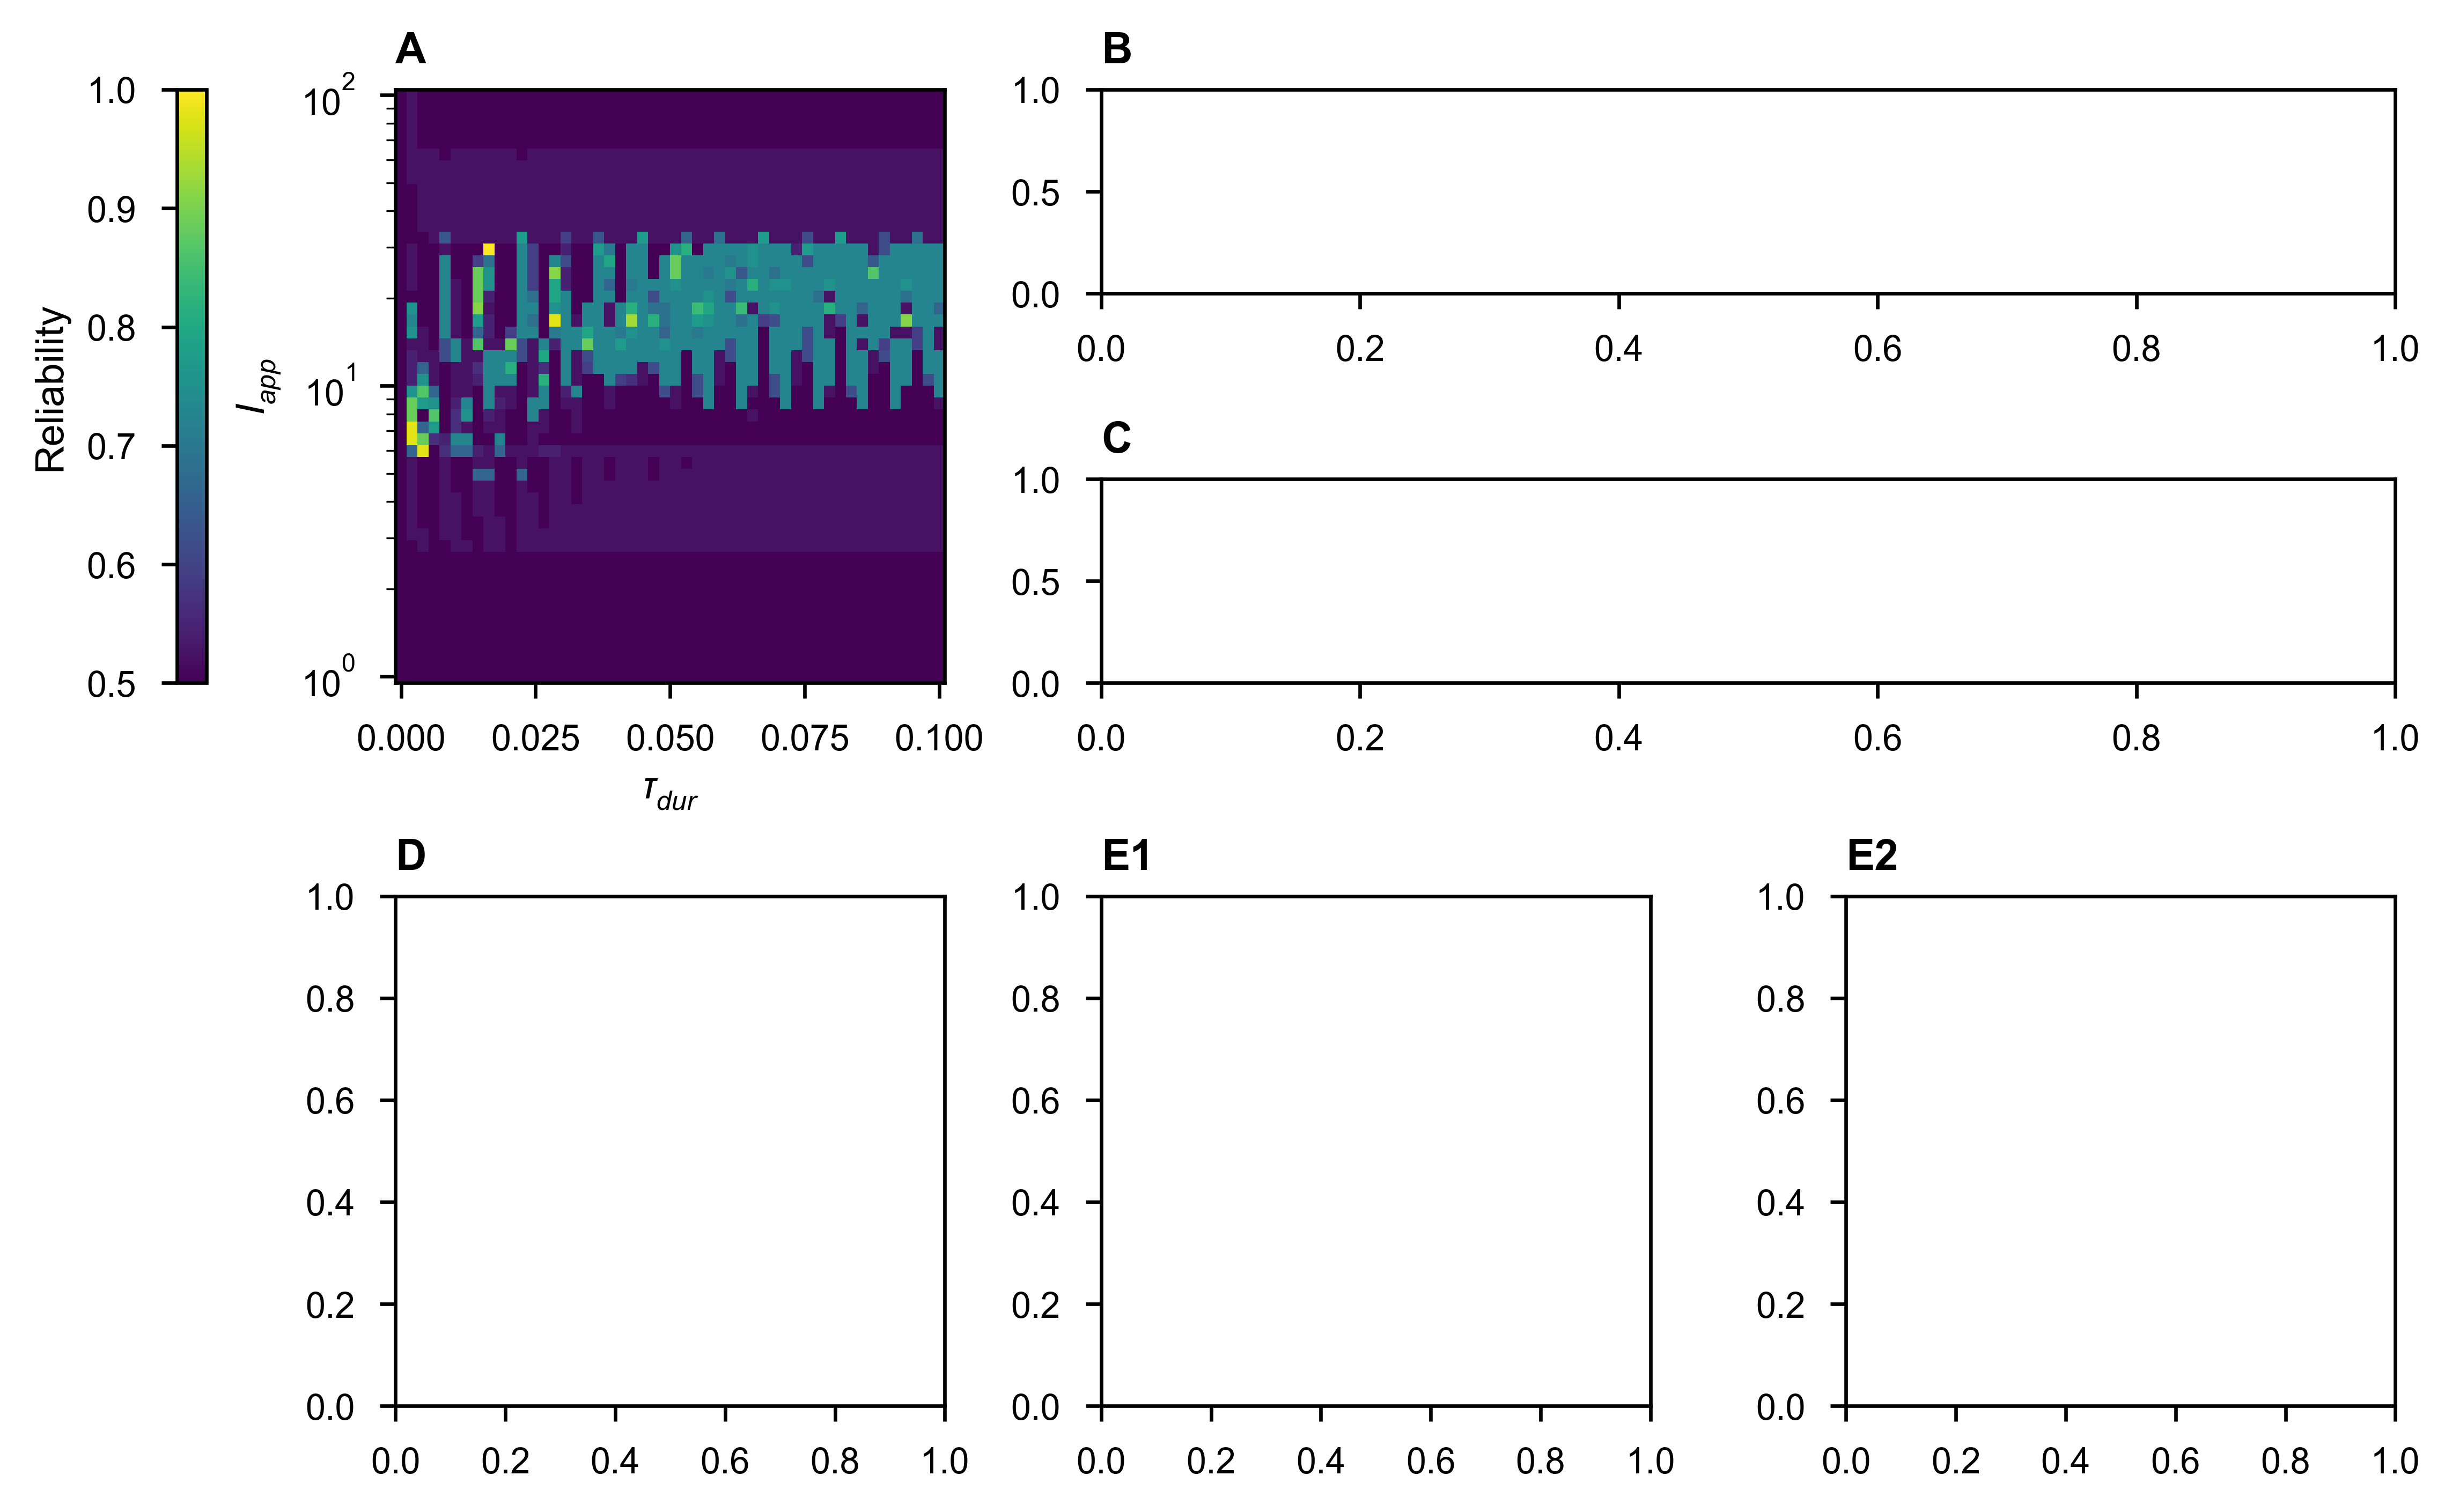

In [33]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(MAX_WIDTH*px, 2750*px))
axd = fig.subplot_mosaic(
    """
    ABB
    ACC
    DEF
    """,
    height_ratios=[1, 1, 2.5]
)
E_count = 1
for label, ax in axd.items():
    if label in ('E', 'F'):
        label = f'E{E_count}'
        E_count += 1
    ax.set_title(label, loc='left', fontweight='bold')

c = plot_reliabilities(axd['A'], 'reliabilities_2.npy')
cbar = fig.colorbar(c, ax=axd['A'], location='left')
cbar.set_label('Reliability')